# Simulated annealing proof of concept

In [107]:
import abc
from time import sleep
from numpy import exp
from numpy.linalg import norm
from numpy.random import rand
from random import sample, shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
def random_partition(length, parts):
    """
    Partitiosn the range 0, 1, 2, ..., `length`-1 into `parts` random classes
    """
    iterable = list(range(length))
    shuffle(iterable)
    indices = [0] + sorted(sample(range(1, length), k=parts-1))
    return [iterable[indices[i]:indices[i+1]] for i in range(parts-1)] + [iterable[indices[-1]:]]


def policy_traversal(policy, points):
    """
    Computes the total traversal time for a policy on a selection of points
    """
    return sum(norm(points[policy[i]] - points[policy[i-1]]) for i, p in enumerate(policy))


def max_policy_traversal(policies, points):
    """
    Computes the worst traversal time of a set of policies on a collection of points
    """
    return max(policy_traversal(policy, points) for policy in policies)


def plot_policies(policies, points, axis=plt):
    """
    Plots a set of traversal policies for a given set of points.
    """
    axis.plot(*points.T, 'o')
    for (i, point) in enumerate(points):
        axis.annotate("${}$".format(i), point)
    for policy in policies:
        axis.fill(*points[policy].T, fill=False)

In [152]:
class StateSpace(abc.ABC):
    @abc.abstractclassmethod
    class State(abc.ABC):
        pass
    
    @abc.abstractmethod
    def cost(self, state: "State") -> float:
        raise NotImplementedError
        
    @abc.abstractmethod
    def neighbor(self, state: "State") -> "State":
        raise NotImplementedError
        
    @abc.abstractmethod
    def random_state(self) -> "State":
        raise NotImplementedError

class Annealer:
    def __init__(self, space: StateSpace, inf_temp=1e-5, discount=0.9, internal_iter=100):
        self.space = space
        self.inf_temperature = inf_temp
        self.discount = discount
        self.internal_iterations = internal_iter
    
    def transition_probability(self, cost1, cost2, temperature) -> float:
        return exp(-(cost2 - cost1) / temperature)
    
    def anneal(self, starting_state: StateSpace.State) -> (StateSpace.State, float):
        state = starting_state
        old_cost = self.space.cost(state)
        temperature = 1e0
        while temperature > self.inf_temperature:
            for _ in range(self.internal_iterations):
                new_state = self.space.neighbor(state)
                new_cost = self.space.cost(new_state)
                if rand() < self.transition_probability(old_cost, new_cost, temperature):
                    state, old_cost = new_state, new_cost
            temperature *= self.discount
        return state, old_cost

In [153]:
class KDroneTour(StateSpace):
    class State(list):
        pass
    
    def __init__(self, points, num_drones):
        self.points = points
        self.num_drones = num_drones
        
    def cost(self, state):
        return max_policy_traversal(state, self.points)
    
    def random_state(self):
        return random_partition(len(self.points), self.num_drones)
    
    def neighbor(self, state):
        return self.random_state()

/home/david/repositories/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


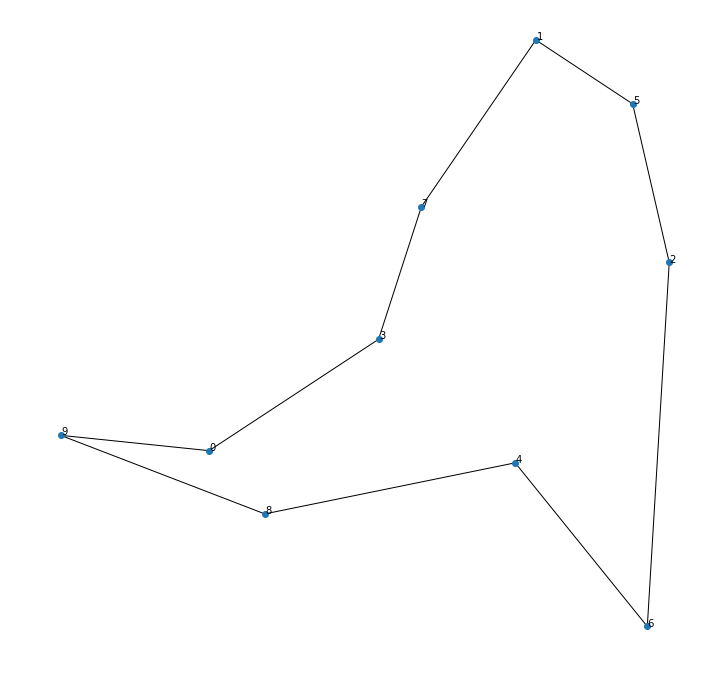

In [159]:
points = rand(10, 2)
annealer = Annealer(KDroneTour(points, 1))
k_tour, penalty = annealer.anneal(annealer.space.random_state())

fig, ax = plt.subplots(1,1, figsize=(12,12))
plot_policies(k_tour, points, axis=ax)
ax.set_aspect('equal')
ax.axis('off');